In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import zipfile
import numpy as np
import matplotlib.pylab as pl

import tensorflow as tf

from IPython.display import Image, HTML, clear_output

import csv
import numpy as np
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)


def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))



def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img




In [ ]:
#@title Choose from one of the avilable 3d object
import pandas as pd
import numpy as np
import io
import requests

# Define available 3D models
AVAILABLE_MODELS = ["torus_19x6x19.csv", "lizard_44x19x8.csv", "bird_15x28x28.csv", "spider_29x10x31.csv", "knight_18x8x15.csv"]
selected_model = "spider_29x10x31.csv"  #@param ["torus_19x6x19.csv", "lizard_44x19x8.csv", "bird_15x28x28.csv", "spider_29x10x31.csv", "knight_18x8x15.csv"]

# URLs for 3D model data
model_urls = {
    'knight': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/knight_18x8x15.csv',
    'bird': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/bird_15x28x28.csv',
    'lizard': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/lizard_44x19x8.csv',
    'torus': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/torus_19x6x19.csv',
    'spider': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/spider_29x10x31.csv'
}

# Extracting the model name from the selected model
model_name = selected_model.split('_')[0]

# Fetching the URL for the selected model
model_url = model_urls[model_name]

try:
    # Loading data from the URL
    model_data = pd.read_csv(model_url, encoding='unicode_escape')
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Converting DataFrame to a NumPy array
model_array = np.array(model_data)

# Extracting file name and dimensions
file_name = model_url.split('/')[-1].split('?')[0].split('.')[0]

x_col = model_data.columns[0]
y_col = model_data.columns[1]
z_col = model_data.columns[2]

size_x = model_data[x_col].max() - model_data[x_col].min()+1
size_y = model_data[y_col].max() - model_data[y_col].min()+1
size_z = model_data[z_col].max() - model_data[z_col].min()+1

# Assigning dimensions
dimensions = size_x, size_y, size_z

# Finding the maximum dimension

# Outputting data information
print('Data loading successful')
print('File name:', file_name)
print('3d model dimention: ', dimensions)
print('Data shape:', model_array.shape)




Data loading successful
File name: spider_29x10x31
3d model dimention:  (29, 10, 31)
Data shape: (1341, 6)


In [ ]:
#@title get single layer
def extract_voxel_layer(voxel_data, z_layer_index, size_x, size_y):
    # Extracting the specified Z layer
    layer_voxels = np.array([voxel_data[voxel_data[:, 2] == z_layer_index]])
    voxel_properties = layer_voxels[0][...,:6].astype(int)

    # Initializing arrays for voxel presence and RGB values
    voxel_presence = np.zeros((size_x, size_y))
    red_channel = np.zeros((size_x, size_y))
    green_channel = np.zeros((size_x, size_y))
    blue_channel = np.zeros((size_x, size_y))

    # Populating the arrays
    for voxel in voxel_properties:
        x, y = voxel[0], voxel[1]
        voxel_presence[x][y] = 1
        red_channel[x][y] = voxel[3]
        green_channel[x][y] = voxel[4]
        blue_channel[x][y] = voxel[5]

    return red_channel, green_channel, blue_channel, voxel_presence


In [ ]:
#@title Stack up layers

r_layers, g_layers, b_layers, z_layers = [], [], [], []

# Iterate through each Z layer
for i in range(size_z):
    r, g, b, a = extract_voxel_layer(model_array, i, size_x, size_y)
    r_layers.append(r)
    g_layers.append(g)
    b_layers.append(b)
    z_layers.append(a)

# Stacking all layers together
r_stack = np.dstack(r_layers)
g_stack = np.dstack(g_layers)
b_stack = np.dstack(b_layers)
z_stack = np.dstack(z_layers)

In [ ]:
#@title Display all layers
import matplotlib.pyplot as plt

def display_all_layers(r_stack, g_stack, b_stack, z_stack, size_x):
    for i in range(size_x):
        # Stacking and normalizing the RGB layers
        img = np.stack((r_stack[i] / 255, g_stack[i] / 255, b_stack[i] / 255, z_stack[i]), axis=2)

        # Displaying the image
        plt.imshow(zoom(img))
        plt.title(f'Layer: {i}')
        plt.show()

# Call the function to display all layers
display_all_layers(r_stack, g_stack, b_stack, z_stack, size_x)


In [ ]:
#@title  Parameters
#@markdown Choose for options below
TRAINING_TYPE = "structure only" #@param ["structure only", "structure with color"]
flag = True if TRAINING_TYPE == "structure with color" else False

FACE_COLOR='dimgray'#@param['sienna','silver','dimgray','k','green']


In [ ]:
target = np.stack((r_stack/255, g_stack/255, b_stack/255, z_stack), axis=-1)

In [ ]:
import numpy as np

def pad_array(arr, dimensions, pad_value=0):
        size_x, size_y, size_z = dimensions
        max_dimension = int(np.max(dimensions))
        return np.pad(arr, (((max_dimension - size_x) // 2, (max_dimension - size_x) // 2),
                           ((max_dimension - size_y) // 2, (max_dimension - size_y) // 2),
                           ((max_dimension - size_z) // 2, (max_dimension - size_z) // 2)),
                      mode='constant', constant_values=pad_value)


def resize_and_pad_stacked_arrays(rgbfz_stack, dimensions, pad_value=0):
    # Extract individual channels from the stacked array
    r_stack = rgbfz_stack[:, :, :, 0]  # Assuming the order is RGBZ
    g_stack = rgbfz_stack[:, :, :, 1]
    b_stack = rgbfz_stack[:, :, :, 2]
    z_stack = rgbfz_stack[:, :, :, 3]

    # Resize and pad each individual array
    r_resized = pad_array(r_stack, dimensions)
    g_resized = pad_array(g_stack, dimensions)
    b_resized = pad_array(b_stack, dimensions)
    z_resized = pad_array(z_stack, dimensions)

    # Stack the resized arrays back together
    target_resized = np.stack((r_resized, g_resized, b_resized , z_resized), axis=-1)

    return target_resized


target_resized = resize_and_pad_stacked_arrays(target, dimensions)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def voxel_visualization(voxel_array, dimensions, flag, FACE_COLOR, save_path=None, figsize=5, azim=0):
    """
    Creates and displays a 3D voxel visualization and optionally saves it to a file.

    Parameters:
    - voxel_array: Input array containing voxel data.
    - dimensions: The dimensions of the array.
    - flag: Boolean to determine color mode.
    - FACE_COLOR: Default face color if flag is False.
    - save_path: Path to save the image file. If None, the image is not saved.
    - figsize: Size of the figure.
    """
    # Assuming resize_and_pad_stacked_arrays is a defined function
    temp = resize_and_pad_stacked_arrays(voxel_array, dimensions)

    fig = plt.figure(figsize=(figsize, figsize))
    ax = fig.add_subplot(projection='3d')

    if flag:
        ax.voxels(temp[...,3], facecolors=temp[..., :4])
    else:
        ax.voxels(temp[...,3], facecolors=FACE_COLOR)

    plt.title('3D Voxel Visualization')
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.view_init(azim=i)

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
        plt.close()

In [ ]:
import plotly.graph_objects as go
import numpy as np

def create_voxel_plot(model_array):
    """
    Creates a 3D scatter plot for voxels based on the provided voxel data.

    Parameters:
    model_array (np.ndarray): A 4D array containing voxel data with dimensions and RGBA values.
    """
    # Create a figure
    fig = go.Figure()

    # Iterate through the voxel data and add cubes for each voxel
    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            for k in range(model_array.shape[2]):
                color = f'rgb({int(model_array[i, j, k, 0]*255)}, {int(model_array[i, j, k, 1]*255)}, {int(model_array[i, j, k, 2]*255)})'
                opacity = model_array[i, j, k, 3]

                if opacity > 0:
                    # Define the vertices of the cube
                    vertices = np.array([
                        [i, j, k],
                        [i + 1, j, k],
                        [i + 1, j + 1, k],
                        [i, j + 1, k],
                        [i, j, k + 1],
                        [i + 1, j, k + 1],
                        [i + 1, j + 1, k + 1],
                        [i, j + 1, k + 1]
                    ])

                    # Define the cube's faces
                    faces = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
                             [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]]

                    # Create the cube's mesh3d object and add it to the figure
                    for face in faces:
                        x = vertices[face, 0]
                        y = vertices[face, 1]
                        z = vertices[face, 2]
                        fig.add_trace(go.Mesh3d(x=x, y=y, z=z, opacity=opacity, color=color))

    # Set layout options
    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=4),
            yaxis=dict(nticks=4),
            zaxis=dict(nticks=4),
        )
    )

    # Show the plot
    fig.show()

create_voxel_plot(target_resized)


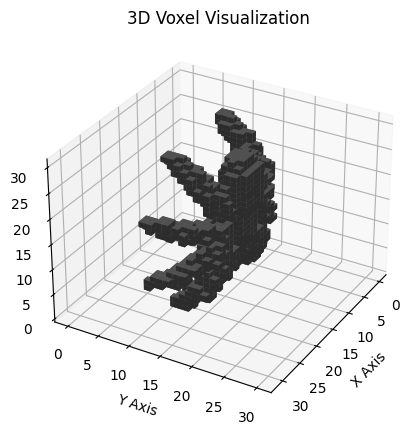

In [ ]:
voxel_visualization(target, dimensions=dimensions, flag=flag, FACE_COLOR=FACE_COLOR)

In [ ]:
#@title Defining seed
#@markdown Choose no of channel

import numpy as np

def create_seed(size_x, size_y, size_z, number_of_channels):
    """
    Creates and initializes a seed array for the simulation.

    Parameters:
    size_x (int): Size of the seed array along the X dimension.
    size_y (int): Size of the seed array along the Y dimension.
    size_z (int): Size of the seed array along the Z dimension.
    number_of_channels (int): Number of channels in the seed array.

    Returns:
    numpy.ndarray: Initialized seed array.
    """
    seed = np.zeros([1, size_x, size_y, size_z, number_of_channels], np.float32)
    seed[:, size_x // 2, size_y // 2, size_z // 2, :4] = 1
    return seed

# Example usage
size_x, size_y, size_z = dimensions
NUMBER_OF_CHANNELS = "16"  #@param [16,20,24]
Channel = int(NUMBER_OF_CHANNELS)
seed = create_seed(size_x, size_y, size_z, Channel)

print("Shape of seed:", seed.shape)



Shape of seed: (1, 29, 10, 31, 16)


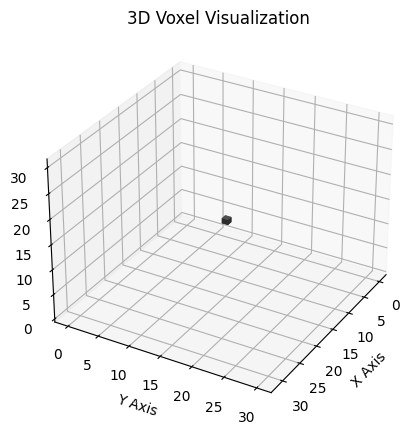

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract and pad the seed channels
seed_data = seed[0][...,:4]

voxel_visualization(seed_data,dimensions=dimensions, flag=flag, FACE_COLOR=FACE_COLOR)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, LeakyReLU
from tensorflow.keras.models import Sequential

def get_living_mask(x):
    alpha = x[..., 3:4]
    return tf.cast(tf.nn.max_pool3d(alpha, 3, 1, 'SAME') > 0.1, tf.float32)

class CA(tf.Module):
    def __init__(self, channel, size_x, size_y, size_z):
        super(CA, self).__init__()
        self.model = Sequential([
            Conv3D(filters=channel , kernel_size=3, padding='same',
                   input_shape=(size_x, size_y, size_z, channel), activation=tf.nn.relu),
            Conv3D(filters=channel*4, kernel_size=3, padding='same',
                   input_shape=(size_x, size_y, size_z, channel), activation=tf.nn.relu),
            Conv3D(filters=channel, kernel_size=1, padding='same',
                   kernel_initializer=tf.zeros)
        ])

    @tf.function
    def __call__(self, x):
        update_mask = tf.floor(tf.random.uniform(x.shape) + 0.5)
        x = x + self.model(x) * update_mask
        x *= get_living_mask(x)
        return x



In [ ]:
#@title Running randomly initialized CA for some ittirations{vertical-output:true}
ca = CA(Channel, size_x, size_y, size_z)

# Set initial state
x=seed

# Set number of iterations for the simulation
iterations = 100

# Run the simulation
for i in range(iterations):
    x = ca(x)

In [ ]:
#@title Model summary
ca.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 29, 10, 31, 16)    6928      
                                                                 
 conv3d_1 (Conv3D)           (None, 29, 10, 31, 64)    27712     
                                                                 
 conv3d_2 (Conv3D)           (None, 29, 10, 31, 16)    1040      
                                                                 
Total params: 35680 (139.38 KB)
Trainable params: 35680 (139.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title Defining loss & train step

# Define batch size
BATCH_SIZE = 1 #@param {type:"slider", min:1, max:16, step:1}

# Define number of iterations for CA model, consider making this a parameter
N="100"#@param[50,100,200]

# Optimizer and learning rate schedule
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000], [1e-3, 3e-4])
trainer = tf.optimizers.Adam(lr)


# Loss function
mse_loss = tf.keras.losses.MeanSquaredError()

def calculate_loss(x,flag):
  if flag:
    return mse_loss(x[..., :4], tf.cast(target, tf.float32))
  else:
    return mse_loss(x[..., :4][...,3], tf.cast(target[...,3], tf.float32))

@tf.function
def training_step():
    with tf.GradientTape() as g:
        # Replicate seed to create a batch
        x = tf.repeat(seed, BATCH_SIZE, 0)

        # Run the CA model for a defined number of iterations
        for i in range(int(N)):
            x = ca(x)

        # Calculate loss
        loss= calculate_loss(x,flag)

    # Calculate and normalize gradients
    params = ca.trainable_variables
    grads = g.gradient(loss, params)
    grads = [g / (tf.norm(g) + 1e-8) for g in grads]

    # Apply gradients
    trainer.apply_gradients(zip(grads, params))

    return loss, x  # Consider returning additional info for monitoring


Target :


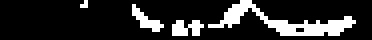

In [ ]:
#@title Refrance layer from target to compare training progerss {vertical-output:true}
print("Target :")

if flag:
  imshow(zoom(np.hstack((target[0, ..., :4],target[7, ..., :4],target[9, ..., :4]))))

else:
  imshow(zoom(np.hstack((target[0, ..., 3],target[7, ..., 3],target[9, ..., 3]))))


Batch : 0 reference layer 0, 7, 9


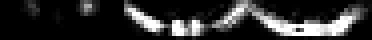

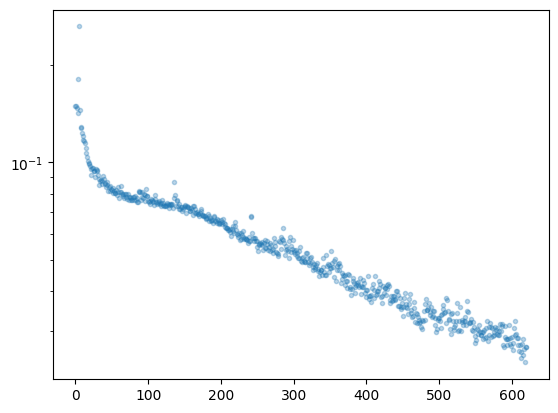

620 0.026750669


KeyboardInterrupt: 

In [ ]:
#@title Train {vertical-output:true}
TRAINING_ITERATION = "1500"  # Define the number of training iterations
loss_log=[]

for i in range(int(TRAINING_ITERATION)):
    x = seed
    loss, x = training_step()
    loss_log.append(loss.numpy())

    if i % 20 == 0:  # Display images and plot loss every 20 iterations
        clear_output(True)
        for n in range(1):
            print("Batch :", n, "reference layer 0, 7, 9")
            temp = x[n][...,:4] if flag else x[n][...,3]
            imshow(zoom(np.hstack((temp[0], temp[7], temp[9]))))
        print()
        pl.plot(loss_log, '.', alpha=0.3)
        pl.yscale('log')
        pl.show()
        print(i, loss.numpy(), flush=True)

# Consider adding final loss plot and checkpoint saving here


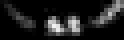


Step N: 90


In [ ]:
#@title Run the trained model
import time
x = seed
iteration = "100"  # Corrected spelling

for i in range(int(iteration)):
    x = ca(x)

    if i % 10 == 0:  # Visualize every 10 iterations for efficiency
        clear_output(True)
        temp = x[0][...,:4]
        if flag:
          imshow(zoom(temp[6][...,:4]))
        else:
          imshow(zoom(temp[6][...,:4][...,3]))
        print()
        print(f'Step N: {i}')
        time.sleep(.5)

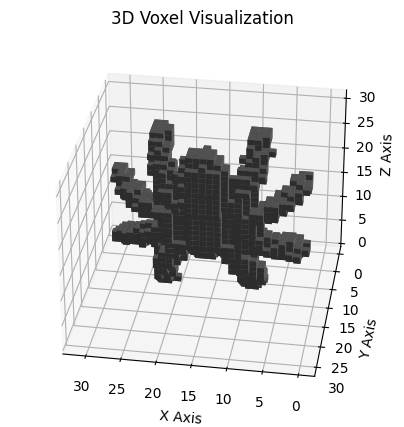

In [ ]:
#@title Final structure generated {vertical-output:true}

temp = x[0][...,:4]
max_v=np.max(temp)
temp=temp/max_v
temp = np.where(temp < 0, 0, temp)

alpha = temp[..., 3]
temp[...,3] = np.where(alpha < 0.1, 0, alpha)

voxel_visualization(temp, dimensions=dimensions, flag=flag, FACE_COLOR=FACE_COLOR)

In [ ]:
#@title Visualize structure generation (plot image  of each stage)
%%capture
x=seed
ittiration="100"#@param[100,120,300]
if not os.path.exists('img'):
  os.mkdir('img')
else:
  import shutil
  shutil.rmtree('img')
  os.mkdir('img')
for i in range(int(ittiration)):
  x=ca(x)
  #if i==60:
    #msk = np.ones([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
    #msk[ 0,:SIZE_X//2,:, :, :] = 0
    #x=x*msk

  clear_output(True)

  temp = x[0][...,:4]
  max_v=np.max(temp)
  temp=temp/max_v
  temp = np.where(temp < 0, 0, temp)
  alpha = temp[..., 3]
  temp[...,3] = np.where(alpha < 0.1, 0, alpha)

  file_path = f"img/voxel_plot_{i}.png"
  voxel_visualization(temp, dimensions = dimensions, flag = flag, FACE_COLOR = FACE_COLOR, save_path = file_path, azim = i)









In [ ]:
#@title Convertingn image sequence to video
from moviepy.editor import ImageSequenceClip

file_list = ["img/voxel_plot_{}.png".format(i) for i in range(1,int(ittiration))]

clip = ImageSequenceClip(file_list, fps=6)
clip.write_videofile("growth.mp4")


Moviepy - Building video growth.mp4.
Moviepy - Writing video growth.mp4



Moviepy - Done !
Moviepy - video ready growth.mp4
